In [2]:
from openai import OpenAI
from dataclasses import dataclass, asdict

from data_utils import local_image_to_data_url

In [ ]:
from configs.openai_config import openai_api


In [ ]:
client = OpenAI(
    **asdict(openai_api)
)
# image_path = "test_figs/given/plot_0_with_axis_border.png"
image_path = "test_figs/given/plot_0_with_axis_border.png"
data_url = local_image_to_data_url(image_path)

chat_completion = client.chat.completions.create(
    temperature=0,
    messages=[
        {
            "role": "user",
            "content": [
                {
				    "type": "text",
				    "text": """I will provide you with an image containing multiple charts. Around the charts, there are some rough coordinate annotations or visual indicators that can help identify the approximate boundaries of each chart. Your task is to identify and return the approximate bounding box coordinates (top-left and bottom-right corners) for each individual chart within the image. For each sub-chart in the figure, tell me the height of the upper bound, the height of the lower bound first. Remember, these heights must only align with the coordinate indicators I provided around the image as well as the grid in the figure. Then output the bounding boxes. You are allowed to output boxes that are too big, but you can not output boxes that are too small that it didn't cover the full sub-chart. The format of the output should be a list of dictionaries, where each dictionary represents a chart and contains its coordinates in the following format:
```json
[
  {"chart_id": 1, "top_left": [x1, y1], "bottom_right": [x2, y2]},
  {"chart_id": 2, "top_left": [x1, y1], "bottom_right": [x2, y2]},
  ...
]```
 The bounding boxes can be slightly larger to ensure the entire chart is included.
""",


                },
                {
					"type": "image_url",
					"image_url":{
						"url": data_url,
                    }
                }

            ],
        }
    ],
    model="gpt-4o",  

)

print(chat_completion.choices[0].message)

ChatCompletionMessage(content='To provide the bounding boxes for the two charts in the image, I\'ll assess the approximate alignment of the charts based on the coordinate grid and visual indicators.\n\n1. **Top Chart:**\n   - Top-left corner: Approx [40, 30]\n   - Bottom-right corner: Approx [850, 230]\n\n2. **Bottom Chart:**\n   - Top-left corner: Approx [40, 260]\n   - Bottom-right corner: Approx [850, 530]\n\nHere is the output in the requested format:\n\n```json\n[\n  {"chart_id": 1, "top_left": [40, 30], "bottom_right": [850, 230]},\n  {"chart_id": 2, "top_left": [40, 260], "bottom_right": [850, 530]}\n]\n```', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None)


In [8]:
box_message = chat_completion.choices[0].message.content
box_list = box_message.split("```")[1]

In [9]:
import json
if box_list.startswith('json'):
    box_list = box_list[4:]
box_list = box_list.strip()
box_list = json.loads(box_list)

In [10]:
box_list
# [{'chart_id': 1, 'top_left': [50, 30], 'bottom_right': [870, 260]},
#  {'chart_id': 2, 'top_left': [50, 290], 'bottom_right': [870, 520]}]

[{'chart_id': 1, 'top_left': [40, 30], 'bottom_right': [850, 230]},
 {'chart_id': 2, 'top_left': [40, 260], 'bottom_right': [850, 530]}]

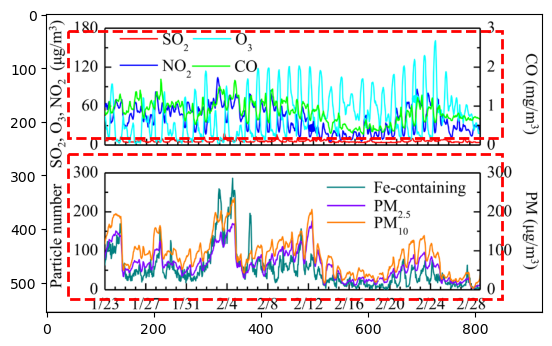

In [11]:
# plot image with bounding boxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
img = Image.open("test_figs/given/plot_0.png")
# img = Image.open("test_figs/given/plot_0_with_axis_border.png")
ax.imshow(np.array(img))

# Create a Rectangle patch

for box in box_list:
    top_left = box['top_left']
    bottom_right = box['bottom_right']
    rect = patches.Rectangle(top_left, bottom_right[0]-top_left[0], bottom_right[1]-top_left[1], linewidth=2, edgecolor='r', facecolor='none', linestyle='--')
    # draw rectangle with dashed line

    
    ax.add_patch(rect)

plt.savefig("test_figs/given/plot_0_with_boxes.png")
plt.show()

In [12]:
addition_prompt = """If one of the chart is the top most one, change the upper bound of its bound box to the top of the figure. If one of the chart is the bottom most one, change the lower bound of its bound box to the bottom of the figure.
Additionally, if two charts are vertically or horizontally adjacent (e.g., one chart's bottom boundary is near another chart's top boundary), adjust the boundary coordinate in question to be the average of the two overlapping boundaries. For example, if Chart 1's bottom boundary is at y = 100 and Chart 2's top boundary is at y = 102, adjust both to y = 101."""
image_path = "test_figs/given/plot_0_with_axis_border.png"
data_url = local_image_to_data_url(image_path)

chat_completion = client.chat.completions.create(
    temperature=0,
    messages=[
        {
            "role": "user",
            "content": [
                {
				    "type": "text",
				    "text": f"""I will provide you with an image containing multiple charts. Around the charts, there are some rough coordinate annotations or visual indicators that can help identify the approximate boundaries of each chart.I have a rough bound box estimation: {box_list}. Help me change my bound box estimation based on the following rules: {addition_prompt}.
                    The format of the output should be a list of dictionaries, where each dictionary represents a chart and contains its coordinates in the following format:
```json
[
  {{"chart_id": 1, "top_left": [x1, y1], "bottom_right": [x2, y2]}},
  {{"chart_id": 2, "top_left": [x1, y1], "bottom_right": [x2, y2]}},
  ...
]```
Each coordinate should represent pixel values relative to the original image. The bounding boxes can be slightly larger to ensure the entire chart is included.
""",


                },
                {
					"type": "image_url",
					"image_url":{
						"url": data_url,
                    }
                }

            ],
        }
    ],
    model="gpt-4o",  

)
message = chat_completion.choices[0].message.content
message


'To adjust your bounding box estimations based on the rules, here\'s the step-by-step process:\n\n1. **Top and Bottom Adjustments:**\n   - Chart 1 is the topmost chart, so adjust its top boundary to the top of the figure (y = 0).\n   - Chart 2 is the bottommost chart, so adjust its bottom boundary to the bottom of the figure (y = 550).\n\n2. **Average Boundary Check:**\n   - Chart 1\'s bottom boundary is at y = 230 and Chart 2\'s top boundary is at y = 260. Calculate the average y-value: (230 + 260) / 2 = 245. Adjust both boundaries to y = 245.\n\nApplying these adjustments, the new bounding boxes are:\n\n```json\n[\n  {"chart_id": 1, "top_left": [40, 0], "bottom_right": [850, 245]},\n  {"chart_id": 2, "top_left": [40, 245], "bottom_right": [850, 550]}\n]\n```'

In [13]:
refined_box_list = message.split("```")[1]
if refined_box_list.startswith('json'):
    refined_box_list = refined_box_list[4:]
refined_box_list = refined_box_list.strip()
refined_box_list = json.loads(refined_box_list)
refined_box_list

[{'chart_id': 1, 'top_left': [40, 0], 'bottom_right': [850, 245]},
 {'chart_id': 2, 'top_left': [40, 245], 'bottom_right': [850, 550]}]

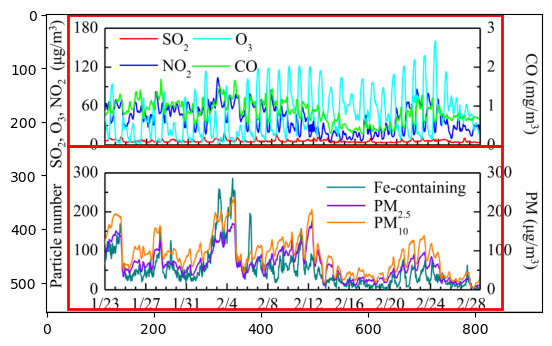

In [14]:
# draw image with refined boxes
fig, ax = plt.subplots()
img = Image.open("test_figs/given/plot_0.png")
ax.imshow(np.array(img))

for box in refined_box_list:
    top_left = box['top_left']
    bottom_right = box['bottom_right']
    rect = patches.Rectangle(top_left, bottom_right[0]-top_left[0], bottom_right[1]-top_left[1], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.savefig("test_figs/given/plot_0_with_refined_boxes.png")
plt.show()


In [ ]:
# image_path = "test_figs/given/plot_0_with_refined_boxes.png"
# image_path = "test_figs/given/plot_0_with_axis_border.png"
image_path = "test_figs/given/plot_0.png"
data_url = local_image_to_data_url(image_path)

extract_info_prompt = f"""
I will provide you with a JSON containing refined bounding box coordinates for multiple sub-charts within an image. Your task is to analyze each sub-chart and extract the following details for each one:

Y-Axis Information:

Label: The text label of the y-axis.
Max: The maximum value on the y-axis.
Min: The minimum value on the y-axis.
Ticks: A list of all tick values on the y-axis (if present).
X-Axis Information:

Label: The text label of the x-axis.
Max: The maximum value on the x-axis.
Min: The minimum value on the x-axis.
Ticks: A list of all tick values on the x-axis (if present).
Sub-Chart Title: The title of the sub-chart (if available).

Plot Information (for sub-charts containing multiple plots):

A list of all plot names and their corresponding colors as specified in the legend. Each entry should include:
Plot name: The name of the plot (as listed in the legend).
Color: The color associated with the plot in the legend.

The input format for the bounding boxes is as follows:
{refined_box_list}

For each sub-chart, extract the necessary information by analyzing the content within the provided bounding box. If any required information is missing or unclear, make a note of it and provide your best estimate or explanation. Please be precise with colors and text labels. For example please don't confuse cyan, green and teal.

The output format should be a list of dictionaries, where each dictionary represents a sub-chart and contains the extracted details:

```json
[
  {{
    "chart_id": 1,
    "top_left": [x1, y1],
    "bottom_right": [x2, y2],
    "y_axis_label": "Label text",
    "y_axis_max": 100,
    "y_axis_min": 0,
    "y_axis_ticks": [0, 20, 40, 60, 80, 100],
    "x_axis_label": "Label text",
    "x_axis_max": 10,
    "x_axis_min": 0,
    "x_axis_ticks": [0, 2, 4, 6, 8, 10],
    "title": "Sub-chart title",
    "plots": [
      {{"name": "Plot 1", "color": "red"}},
      {{"name": "Plot 2", "color": "blue"}}
    ]
  }},
  {{
    "chart_id": 2,
    ...
  }}
]
```
If a certain axis or title is missing, just output null.
"""

chat_completion = client.chat.completions.create(
    temperature=0,
    messages=[
        {
            "role": "user",
            "content": [
                {
				    "type": "text",
				    "text": extract_info_prompt
                },
                {
					"type": "image_url",
					"image_url":{
						"url": data_url,
                    }
                }

            ],
        }
    ],
    model="gpt-4o",  

)
message = chat_completion.choices[0].message.content
message

'```json\n[\n  {\n    "chart_id": 1,\n    "top_left": [40, 0],\n    "bottom_right": [850, 245],\n    "y_axis_label": "SO₂, O₃, NO₂ (µg/m³)",\n    "y_axis_max": 180,\n    "y_axis_min": 0,\n    "y_axis_ticks": [0, 60, 120, 180],\n    "x_axis_label": null,\n    "x_axis_max": null,\n    "x_axis_min": null,\n    "x_axis_ticks": null,\n    "title": null,\n    "plots": [\n      {"name": "SO₂", "color": "red"},\n      {"name": "O₃", "color": "cyan"},\n      {"name": "NO₂", "color": "blue"},\n      {"name": "CO", "color": "green"}\n    ]\n  },\n  {\n    "chart_id": 2,\n    "top_left": [40, 245],\n    "bottom_right": [850, 550],\n    "y_axis_label": "Particle number",\n    "y_axis_max": 300,\n    "y_axis_min": 0,\n    "y_axis_ticks": [0, 100, 200, 300],\n    "x_axis_label": null,\n    "x_axis_max": null,\n    "x_axis_min": null,\n    "x_axis_ticks": ["1/23", "1/27", "1/31", "2/4", "2/8", "2/12", "2/16", "2/20", "2/24", "2/28"],\n    "title": null,\n    "plots": [\n      {"name": "Fe-containing",

In [26]:
print(message)

```json
[
  {
    "chart_id": 1,
    "top_left": [40, 0],
    "bottom_right": [850, 245],
    "y_axis_label": "SO₂, O₃, NO₂ (µg/m³)",
    "y_axis_max": 180,
    "y_axis_min": 0,
    "y_axis_ticks": [0, 60, 120, 180],
    "x_axis_label": null,
    "x_axis_max": null,
    "x_axis_min": null,
    "x_axis_ticks": null,
    "title": null,
    "plots": [
      {"name": "SO₂", "color": "red"},
      {"name": "O₃", "color": "cyan"},
      {"name": "NO₂", "color": "blue"},
      {"name": "CO", "color": "green"}
    ]
  },
  {
    "chart_id": 2,
    "top_left": [40, 245],
    "bottom_right": [850, 550],
    "y_axis_label": "Particle number",
    "y_axis_max": 300,
    "y_axis_min": 0,
    "y_axis_ticks": [0, 100, 200, 300],
    "x_axis_label": null,
    "x_axis_max": null,
    "x_axis_min": null,
    "x_axis_ticks": ["1/23", "1/27", "1/31", "2/4", "2/8", "2/12", "2/16", "2/20", "2/24", "2/28"],
    "title": null,
    "plots": [
      {"name": "Fe-containing", "color": "teal"},
      {"name": "PM

In [ ]:
image_with_boxes_path = "test_figs/given/plot_0_with_boxes.png"
data_url = local_image_to_data_url(image_with_boxes_path)

chat_completion = client.chat.completions.create(
    temperature=0,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": f"""You have identified the bounding boxes for each individual chart in the image. The coordinates for each bounding box is {box_list}. Here is the image with the bounding boxes drawn around each chart. Please review the bounding boxes and let me know if any adjustments are needed. Before giving me the final output, for each bounding box , tell me if the upper bound is above upper axis of the chart, if so, then no change if required. Do the same for lower bound, if the lower bound is below the lower axis, then no change is required, else move it down. Do the same for the left bound and the right bound. If any change is required, please provide the new coordinates for the bounding box in the following format:
                    Output your adjustments in the following format:
                    [
                      {{"chart_id": 1, "top_left": [x1, y1], "bottom_right": [x2, y2]\}},
                      {{"chart_id": 2, "top_left": [x1, y1], "bottom_right": [x2, y2]}},
                      ...
                    ]
                    """
                },
                {
                    "type": "image_url",
                    "image_url":{
                        "url": data_url,
                    }
                }

            ],
        }
    ],
    model="gpt-4o",  

)

In [135]:
message = chat_completion.choices[0].message.content
message

'Let\'s review the bounding boxes based on the provided image:\n\n1. **Chart 1:**\n\n   - **Upper Bound (y-coordinate):** The upper bound [30] is above the upper axis of the chart, so no change is required.\n   - **Lower Bound (y-coordinate):** The lower bound [220] is below the lower axis of the chart, so no change is required.\n   - **Left Bound (x-coordinate):** The left bound [50] seems to encapsulate the chart properly, so no change is required.\n   - **Right Bound (x-coordinate):** The right bound [850] seems to encapsulate the chart properly, so no change is required.\n\n2. **Chart 2:**\n\n   - **Upper Bound (y-coordinate):** The upper bound [260] is above the upper axis of the chart, so no change is required.\n   - **Lower Bound (y-coordinate):** The lower bound [460] is below the lower axis of the chart, so no change is required.\n   - **Left Bound (x-coordinate):** The left bound [50] seems to encapsulate the chart properly, so no change is required.\n   - **Right Bound (x-co

In [136]:
refined_box_list = message.split("```")[1]
if refined_box_list.startswith('json'):
    refined_box_list = refined_box_list[4:]
refined_box_list = refined_box_list.strip()
refined_box_list = json.loads(refined_box_list)


In [137]:
refined_box_list

[{'chart_id': 1, 'top_left': [50, 30], 'bottom_right': [850, 220]},
 {'chart_id': 2, 'top_left': [50, 260], 'bottom_right': [850, 460]}]

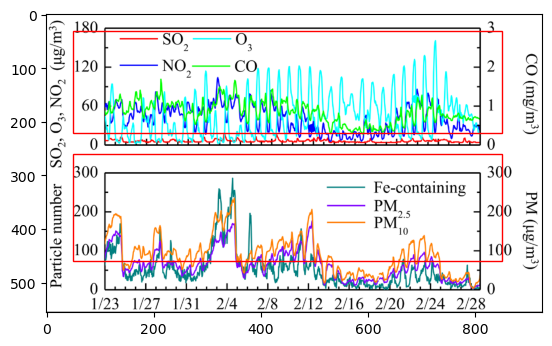

In [138]:
# draw image with refined boxes
fig, ax = plt.subplots()
img = Image.open("test_figs/given/plot_0.png")
ax.imshow(np.array(img))

for box in refined_box_list:
    top_left = box['top_left']
    bottom_right = box['bottom_right']
    rect = patches.Rectangle(top_left, bottom_right[0]-top_left[0], bottom_right[1]-top_left[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()


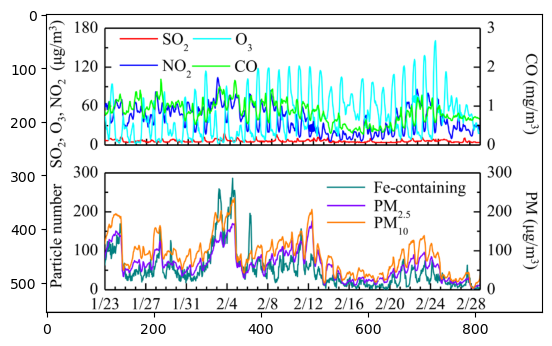

In [88]:
fig, ax = plt.subplots()
img = Image.open(image_path)
ax.imshow(np.array(img))
plt.savefig("test_figs/given/plot_0_with_axis_border.png")
plt.show()

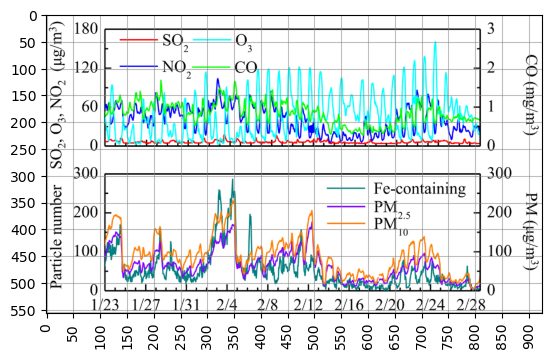

In [126]:
fig, ax = plt.subplots()
height, width, _ = np.array(img).shape
tick_pixel = 50
# Set custom ticks every 20 pixels
x_ticks = range(0, width, tick_pixel)
y_ticks = range(0, height, tick_pixel)

ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
# rotate x-axis labels
plt.xticks(rotation=90)

# Optionally, add grid lines for better visualization (optional)
ax.grid(visible=True, linestyle='-', color='gray', alpha=0.5)
ax.imshow(img)
# plt.padding = 0
plt.savefig("test_figs/given/plot_0_with_axis_border.png", bbox_inches='tight', pad_inches=0)
plt.show()